In [1]:
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from osgeo import osr, ogr, gdal
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np 

import tensorflow.keras

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# Параметры
path_train = "files 2/train_2.png" 
path_target = "files 2/target_2.png" 

size = 32

In [3]:
def split_image(path, size, save_path=None):
    img = Image.open(path).convert('L') 
    x, y = img.size  # ширина (x) и высота (y) изображения
    
#     x = x - size
#     y = y - size
    x = x // size
    y = y // size

    all_data = [] 

    for i in tqdm(range(x)):
        for j in range(y): 
            mini_image = img.crop(box=(size * i, size * j, size * (i + 1), size * ( j + 1)))
            if save_path:
                mini_image.save(save_path + 'image{}.png'.format(str(j + i*y)))

            mini_image = np.array(mini_image.getdata())
            mini_image = np.reshape(mini_image, (1, size, size, 1)) 

            if len(all_data) == 0:
                all_data =  mini_image
            else:
                all_data = np.append(all_data, mini_image, axis=0) 
    print(np.shape(all_data)) 
    return all_data, [x, y]

In [4]:
target, target_size = split_image(path_target, size, "files 2/target_2_splited/")

100%|██████████| 16/16 [00:00<00:00, 24.81it/s]

(128, 32, 32, 1)


In [5]:
train, train_size = split_image(path_train, size, "files 2/train_2_splited/")

100%|██████████| 16/16 [00:00<00:00, 176.72it/s]

(128, 32, 32, 1)


In [68]:
train.max()

1.0

In [67]:
target.max()

1.0

In [6]:
target = target / 255.0 
# target = (target / 127.5) - 1 
train = train / train.max()
# train = train / (train.max() / 2) - 1 

In [7]:
target = np.reshape(target, (-1, size*size)) 

In [28]:
unique, counts = np.unique(target, return_counts=True)
all = dict(zip(unique, counts))
all[1.0] / all[0.0]

0.0405435923323193

In [13]:
# class ComputeSum(keras.layers.Layer):
#     def __init__(self, input_dim):
#         super(ComputeSum, self).__init__()
#         self.total = tf.Variable(initial_value=tf.zeros((input_dim,)), trainable=False)

#     def call(self, inputs):
#         self.total.assign_add(tf.reduce_sum(inputs, axis=0))
#         return self.total

In [137]:
# class Linear(keras.layers.Layer):
#     def __init__(self, units=32):
#         super(Linear, self).__init__()
#         self.units = units

#     def build(self, input_shape):        
        
#         self.w = self.add_weight(
#             shape=(input_shape[-1], self.units),
#             initializer=keras.initializers.Constant(value=100),
#             trainable=False,
#         ) 
        
# #         self.w = np.array([100] *input_shape[-1] )
# #         self.w = np.reshape(self.w, (-1, 1))

#     def call(self, inputs):
# #         print(self.w.value())
#         return tf.matmul(inputs, self.w)  


In [127]:
# model.layers


In [136]:
# first_layer_weights = model.layers[6].get_weights()
# first_layer_weights

[]

In [105]:
len(model.layers)

9

In [8]:
inp = Input(shape=(size, size, 1))
x = Conv2D(256, (14,14), padding='same', activation=tf.nn.relu) (inp)
x = MaxPooling2D((2, 2), strides=2)(x)
x = Conv2D(128, (9,9), padding='same', activation=tf.nn.relu)(x)
x = MaxPooling2D((2, 2), strides=2)(x)
x = Conv2D(90, (7,7), padding='same', activation=tf.nn.relu)(x)
x = MaxPooling2D((2, 2), strides=2)(x)
x = Flatten()(x)
x = Dense(130, activation=tf.nn.relu)(x) 
x = Dropout(0.5)(x)
x = Dense(130, activation=tf.nn.relu)(x) 
x = Dropout(0.5)(x)
out = Dense(size*size,  activation=tf.nn.softmax)(x)

model = Model(inputs=inp, outputs=out)

In [23]:
model = Sequential([
    Conv2D(512, (7,7), padding='same', activation=tf.nn.relu,
                           input_shape=(size, size, 1)),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(256, (5,5), padding='same', activation=tf.nn.relu), 
    MaxPooling2D((2, 2), strides=2), 
    Flatten(),
    Dense(130, activation=tf.nn.relu),
#     Linear(),
    Dense(130, activation=tf.nn.relu),
    Dense(size*size,  activation=tf.nn.softmax, dtype='float64')
])


In [87]:
# model = Sequential([
#     Conv2D(128, (9,9), padding='same', activation=tf.nn.relu,
#                            input_shape=(size, size, 1)),
#     MaxPooling2D((2, 2), strides=2),
#     Conv2D(256, (9,9), padding='same', activation=tf.nn.relu), 
#     MaxPooling2D((2, 2), strides=2),
#     Flatten(),
#     Dense(130, activation=tf.nn.relu),
#     Dense(130, activation=tf.nn.relu),
#     Dense(size*size,  activation=tf.nn.softmax)
# ])


In [16]:
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.1)

In [17]:


model.compile(optimizer=opt,
              loss='binary_crossentropy',       # categorical_crossentropy, mean_squared_error, binary_crossentropy
              metrics=['binary_accuracy'])

In [18]:
his = model.fit(train, target, epochs=4000, shuffle=True)

Epoch 1/4000
4/4 [==============================] - 1s 48ms/step - loss: 0.4764 - binary_accuracy: 0.9589
Epoch 2/4000
4/4 [==============================] - 0s 47ms/step - loss: 0.6018 - binary_accuracy: 0.9609
Epoch 3/4000
4/4 [==============================] - 0s 47ms/step - loss: 0.6542 - binary_accuracy: 0.9574
Epoch 4/4000
4/4 [==============================] - 0s 51ms/step - loss: 0.6486 - binary_accuracy: 0.9578
Epoch 5/4000
4/4 [==============================] - 0s 50ms/step - loss: 0.7154 - binary_accuracy: 0.9535
Epoch 6/4000
4/4 [==============================] - 0s 48ms/step - loss: 0.7092 - binary_accuracy: 0.9539
Epoch 7/4000
4/4 [==============================] - 0s 47ms/step - loss: 0.6677 - binary_accuracy: 0.9566
Epoch 8/4000
4/4 [==============================] - 0s 49ms/step - loss: 0.6275 - binary_accuracy: 0.9592
Epoch 9/4000
4/4 [==============================] - 0s 49ms/step - loss: 0.6785 - binary_accuracy: 0.9559
Epoch 10/4000
4/4 [===========================

4/4 [==============================] - 0s 47ms/step - loss: 0.5249 - binary_accuracy: 0.9659
Epoch 78/4000
4/4 [==============================] - 0s 46ms/step - loss: 0.6115 - binary_accuracy: 0.9603
Epoch 79/4000
4/4 [==============================] - 0s 46ms/step - loss: 0.6047 - binary_accuracy: 0.9607
Epoch 80/4000
4/4 [==============================] - 0s 49ms/step - loss: 0.7306 - binary_accuracy: 0.9525
Epoch 81/4000
4/4 [==============================] - 0s 49ms/step - loss: 0.4875 - binary_accuracy: 0.9683
Epoch 82/4000
4/4 [==============================] - 0s 51ms/step - loss: 0.5246 - binary_accuracy: 0.9659
Epoch 83/4000
4/4 [==============================] - 0s 49ms/step - loss: 0.6565 - binary_accuracy: 0.9573
Epoch 84/4000
4/4 [==============================] - 0s 46ms/step - loss: 0.5134 - binary_accuracy: 0.9666
Epoch 85/4000
4/4 [==============================] - 0s 48ms/step - loss: 0.6854 - binary_accuracy: 0.9555
Epoch 86/4000
4/4 [==============================] 

4/4 [==============================] - 0s 46ms/step - loss: 0.5865 - binary_accuracy: 0.9619
Epoch 154/4000
4/4 [==============================] - 0s 46ms/step - loss: 0.6048 - binary_accuracy: 0.9607
Epoch 155/4000
4/4 [==============================] - 0s 47ms/step - loss: 0.4940 - binary_accuracy: 0.9679
Epoch 156/4000
4/4 [==============================] - 0s 47ms/step - loss: 0.5621 - binary_accuracy: 0.9635
Epoch 157/4000
4/4 [==============================] - 0s 46ms/step - loss: 0.7041 - binary_accuracy: 0.9542
Epoch 158/4000
4/4 [==============================] - 0s 47ms/step - loss: 0.5895 - binary_accuracy: 0.9617
Epoch 159/4000
4/4 [==============================] - 0s 50ms/step - loss: 0.6231 - binary_accuracy: 0.9595
Epoch 160/4000
4/4 [==============================] - 0s 47ms/step - loss: 0.6950 - binary_accuracy: 0.9549
Epoch 161/4000
4/4 [==============================] - 0s 47ms/step - loss: 0.7008 - binary_accuracy: 0.9544
Epoch 162/4000
4/4 [=======================

KeyboardInterrupt: 

In [168]:

np.finfo(train[test_index].max())

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

In [40]:
# his.history

In [ ]:
model.summary() 

In [152]:
test_index = 32

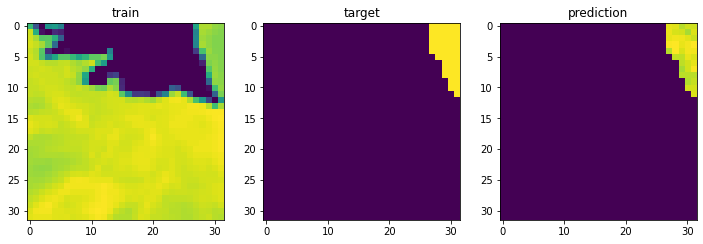

prediction max value =  0.024703778
prediction min value =  2.728938e-12
prediction mean value =  0.0009765624


In [26]:
b = np.reshape(train[test_index], (1, size, size, 1))
prediction = model.predict(b) 
prediction = np.reshape(prediction, (size, size)) 

train_img = np.reshape(train[test_index], (size, size)) 
target_img = np.reshape(target[test_index], (size, size)) 

fig, axes = plt.subplots(1, 3)

axes[0].imshow(train_img)
axes[0].set_title('train')

axes[1].imshow(target_img)
axes[1].set_title('target')

axes[2].imshow(prediction)
axes[2].set_title('prediction')

fig.set_figwidth(12)    #  ширина и
fig.set_figheight(6)    #  высота "Figure"
plt.show()
print("prediction max value = ", prediction.max())
print("prediction min value = ", prediction.min())
print("prediction mean value = ", prediction.mean())

In [96]:
 (prediction*1000).max()

4.0536766

100%|██████████| 17/17 [00:00<00:00, 745.36it/s]


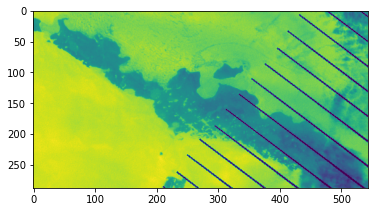

In [121]:
img = Image.new('L', (size*train_size[0], size*train_size[1]))

for i in tqdm(range(train_size[0])):
    for j in range(train_size[1]):

        train_img = np.reshape(train[i * train_size[1] + j], (size, size)) 
        a = train_img.astype('uint8') 
        img1 =  Image.fromarray(a)
        img.paste(img1, (i*size, j*size))
        
img.save("2.png")
plt.imshow(img) 

100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


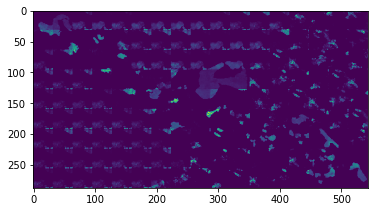

In [26]:
img = Image.new('L', (size*train_size[0], size*train_size[1]))

for i in tqdm(range(train_size[0])):
    for j in range(train_size[1]):

        b = np.reshape(train[i * train_size[1] + j], (1, size, size, 1))
        prediction = model.predict(b)
        prediction = prediction * 10000
        
        train_img = np.reshape(prediction, (size, size)) 
        a = train_img.astype('uint8') 
        img1 =  Image.fromarray(a)
        img.paste(img1, (i*size, j*size))
        

plt.imshow(img) 
# img.save("1_2_25612890.png")

In [26]:
print(prediction)

[[1.1317295e-09 5.2061274e-08 6.8524901e-07 ... 4.2793651e-08
  1.8844513e-07 7.1384704e-08]
 [1.1396277e-08 2.8596627e-08 3.2344158e-07 ... 2.6575032e-08
  4.8888474e-08 4.6598196e-09]
 [3.1485685e-09 2.5167264e-08 2.2362080e-08 ... 2.2740403e-07
  2.9930806e-07 1.2725336e-07]
 ...
 [2.8482857e-06 2.0997115e-06 1.7216238e-06 ... 1.2906146e-05
  7.5013650e-06 9.0720559e-06]
 [7.6661464e-03 7.4512274e-03 1.2095799e-06 ... 6.9532134e-06
  9.9646077e-06 9.5794658e-06]
 [7.6260320e-03 7.4983542e-03 7.5413492e-03 ... 7.0676970e-06
  5.2254068e-06 6.1871892e-06]]


In [17]:
i = 0
# поиск индекса картинки с маской = 1
while (target[i].max() < 1):
    i+=1
print(i)

31


In [13]:
model_name = "model_3conv512_256_128_inp=32_e=7000"

In [14]:
path = f'models/1/{model_name}.h5'
model.save(path)  

In [63]:
path = f'models/1/{model_name}.h5'
model = tf.keras.models.load_model(path)